<img src="img/pypesto_logo.png" width="40%" alt="pyPESTO logo"/>

# A Python Package for Parameter Estimation and Uncertainty Quantification


This jupyter notebook accompanies my talk at the [COMBINE conference 2020](http://co.mbine.org/events/COMBINE_2020). 

[PyPESTO](https://github.com/ICB-DCM/pyPESTO) is a a python package parameter inference. PyPESTO offers a unified interface to various optimization and sampling methods. 

As a design principle, pyPESTO is highly modular and customizable with respect to objective function definition algorithms used for data analysis.

In [1]:
import pypesto
import pypesto.petab 
import pypesto.optimize as optimize
import pypesto.visualize as visualize

import petab
import amici
import os.path
import numpy as np

# import matplotlib and increase image resolution
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

# Objective Definition

PyPESTO allows the definition of a custom objectives, as well as offers support for objectives defined in the [PEtab](https://github.com/PEtab-dev/PEtab) format.

## Custom Objective Definition

The user can define an objective by providing a python function. Further more providing an analytical gradient (and potentiall also a hessian) are known to improve the performance of Gradient/Hessian-based optimizers.  When acessing parameter uncertainties via profile-likelihoods/sampling, the objective function is interpreted as the negative-log-likelihood/negative-log-posterior.

In [2]:
# define objective function
def f(x: np.array):
    return x[0]**2 + x[1]**2

# define gradient
def grad(x: np.array):
    return 2*x

# define objective
custom_objective = pypesto.Objective(fun=f, grad=grad)

Lower and upper parameter bounds are defined and an optimization problem is created. 

In [3]:
# define optimization bounds
lb = np.array([-10, -10])
ub = np.array([10, 10])

# create problem
custom_problem = pypesto.Problem(objective=custom_objective, lb=lb, ub=ub)

Now an optimizer is choosen to perform the minimization. `minimize` uses multi-start optimization, meaning that the optimzation is run `n_start` times from different initial values, in case the problem contians multiple local optima (which of course is not the case for this toy problem).

In [4]:
# choose optimizer
optimizer = optimize.ScipyOptimizer()

# do the optimization
result_custom_problem = optimize.minimize(problem=custom_problem, 
                                          optimizer=optimizer,
                                          n_starts=10)

`result_custom_problem.optimize_result` now stores a list, that contains the results and meta data of the individual optimizer runs (ordered by function value).

In [5]:
# E.g. The best model fit was obtained by the following optimization run:
result_custom_problem.optimize_result.list[0]

{'id': '4',
 'x': array([0., 0.]),
 'fval': 0.0,
 'grad': array([0., 0.]),
 'hess': None,
 'res': None,
 'sres': None,
 'n_fval': 4,
 'n_grad': 4,
 'n_hess': 0,
 'n_res': 0,
 'n_sres': 0,
 'x0': array([-2.9850544 ,  7.73539549]),
 'fval0': 68.74689313005891,
 'history': <pypesto.objective.history.History at 0x7f8b98b9be10>,
 'exitflag': 0,
 'time': 0.0007619857788085938,
 'message': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'}

In [6]:
# Objective function values of the different optimizer runs:
result_custom_problem.optimize_result.get_for_key('fval')

[0.0,
 0.0,
 0.0,
 0.0,
 1.8807909613156592e-37,
 7.523163845262633e-37,
 3.01000022207432e-36,
 3.761581922631319e-36,
 3.76158192263132e-36,
 1.5046327690525275e-35]

## Problem Definition via PEtab

### Background on PEtab

<img src="img/petab_concept.png" width="80%" alt="pyPESTO logo"/>

PyPESTO supports the [PEtab](https://github.com/PEtab-dev/PEtab) standard. PEtab is a data format for specifying parameter estimation problems in systems biology. 

A PEtab problem consist of an [SBML](http://sbml.org/Main_Page) file, defining the model topology and a set of `.tsv` files, defining experimental conditions, observables, measurements and parameters (and their optimization bounds, scale, priors...). All files, that make up a PEtab problem, can be structured in a `.yaml` file. The `pypesto.Objective` comming from a PEtab problem corresponds to the negative-log-likelihood/negative-log-posterior disrtibution of the parameters.  

For more details on PEtab, the interested reader is refered to [PEtab's format definition](https://github.com/PEtab-dev/PEtab/blob/master/doc/documentation_data_format.rst), for examples, the reader is refered to the [PEtab benchmark collection](https://github.com/Benchmarking-Initiative/Benchmark-Models-PEtab). The Model from _[Böhm et al. JProteomRes 2014](https://pubs.acs.org/doi/abs/10.1021/pr5006923)_ is part of the benchmark collection and will be used as the running example throughout this notebook.

PyPESTO provides an interface to the model simulation tool [AMICI](https://github.com/AMICI-dev/AMICI) for the simulation of Ordinary Differential Equation (ODE) models specified in the SBML format.

### Basic Model Import and Optimization 

The first step is to import a PEtab problem and create a `pypesto.problem` object:

In [7]:
%%capture
# directory of the PEtab problem
petab_yaml = './Boehm_JProteomeRes2014/Boehm_JProteomeRes2014.yaml' 

importer = pypesto.petab.PetabImporter.from_yaml(petab_yaml)
problem = importer.create_problem()

Next, we choose an `optimizer` to perform the multi start optimization.

In [8]:
%%time
%%capture

# choose optimizer
optimizer = optimize.ScipyOptimizer()

# do the optimization
result = optimize.minimize(problem=problem, 
                           optimizer=optimizer,
                           n_starts=10)

CPU times: user 13.6 s, sys: 374 ms, total: 14 s
Wall time: 13.9 s


`result.optimize_result` contains a list with the ordered optimization results.

In [9]:
# E.g. best model fit was obtained by the following optimization run:
result.optimize_result.list[0]

{'id': '2',
 'x': array([-1.50318127, -3.35644092,  3.57911933, -1.77791742, -1.75866862,
         3.98199181,  0.693     ,  0.63201064,  0.78932529,  0.73480249,
         0.107     ]),
 'fval': 147.5440161013669,
 'grad': array([-9.53975550e-04,  5.26505577e-05, -1.30918401e-04,  2.35903526e-04,
        -1.62463737e-03,  1.28445768e-03,             nan, -1.97723053e-04,
        -3.86214512e-04,  1.08223041e-03,             nan]),
 'hess': None,
 'res': None,
 'sres': None,
 'n_fval': 115,
 'n_grad': 115,
 'n_hess': 0,
 'n_res': 0,
 'n_sres': 0,
 'x0': array([ 1.75700067, -3.97821777,  3.57796407, -4.05098288, -1.97462675,
        -0.82156354,  0.693     ,  4.35006428,  1.85725115, -4.03875478,
         0.107     ]),
 'fval0': 378727362537.04645,
 'history': <pypesto.objective.history.History at 0x7f8b91f29d30>,
 'exitflag': 0,
 'time': 1.3837461471557617,
 'message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'}

In [10]:
# Objective function values of the different optimizer runs:
result.optimize_result.get_for_key('fval')

[147.5440161013669,
 147.76480081116253,
 149.58782961734158,
 150.7711567620618,
 154.16220714692327,
 154.7331369022563,
 158.81057256773764,
 249.74597138054213,
 249.745997380024,
 249.7459974431457]

## Optimizer Choice

PyPESTO provides a unified interface to a variety of optimizers of different types:

* All [scipy optimizer](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) (`optimize.ScipyOptimizer(method=<method_name>)`)
    * _function-value_ or _least-squares_-based optimizers
    * _gradient_ or _hessian_-based optimizers
* [IpOpt](https://pypi.org/project/ipopt/) (`optimize.IpoptOptimizer()`)
    * Interior point method
* [Dlib](http://dlib.net) (`optimize.DlibOptimizer(options={'maxiter': <max. number of iterations>})`)
    * Global optimizer
    * Gradient free
* [Particle Swarm](https://github.com/tisimst/pyswarm) (`optimize.PyswarmOptimizer()`)
    * Particle swarm algorithm
    * Gradient free
* [CMA-ES](https://pypi.org/project/cma-es/) (`optimize.CmaesOptimizer()`)
    * Covariance Matrix Adaptation Evolution Strategy
    * Evolutionary Algorithm

In [11]:
optimizer_scipy_lbfgsb = optimize.ScipyOptimizer(method='L-BFGS-B')
optimizer_scipy_powell = optimize.ScipyOptimizer(method='Powell')

optimizer_dlib = optimize.DlibOptimizer()
optimizer_pyswarm = optimize.PyswarmOptimizer()

The following performs 100 multi-start runs with different optimizers in order to compare their performance. 

_Note_: `dlib` and `pyswarm` need to be installed for this section to run. Furthermore the computation time is in the order of minutes, so you might want to skip the excecution and jump to the section on large scale models.  

In [12]:
%%time
%%capture
n_starts = 100

# Due to run time we already use parallelization. 
# This will be introduced in more detail later.
engine = pypesto.engine.MultiProcessEngine()
history_options = pypesto.HistoryOptions(trace_record=True)

# Scipy: L-BFGS-B
result_lbfgsb = optimize.minimize(problem=problem, 
                                  optimizer=optimizer_scipy_lbfgsb,
                                  engine=engine,
                                  history_options=history_options,
                                  n_starts=n_starts)

# Scipy: Powell
result_powell = optimize.minimize(problem=problem, 
                              optimizer=optimizer_scipy_powell,
                              engine=engine,
                              history_options=history_options,
                              n_starts=n_starts)

# Dlib
result_dlib = optimize.minimize(problem=problem, 
                                optimizer=optimizer_dlib,
                                engine=engine,
                                history_options=history_options,
                                n_starts=n_starts)


# PySwarm
result_pyswarm = optimize.minimize(problem=problem, 
                                   optimizer=optimizer_pyswarm,
                                   engine=engine,
                                   history_options=history_options,
                                   n_starts=n_starts) 

CPU times: user 9.15 s, sys: 1.79 s, total: 10.9 s
Wall time: 39min 30s


## Optimizer Convergence


A common visualization of optimizer convergence are waterfall plots. Waterfall plots show the (ordered) results of the individual optimization runs. As we see below, Dlib and pyswarm, which are not gradient based, are not able to find the global optimum. 

Furthermore we hope to obtain clearly visible plateaus, as they indicate optimizer convergence to local minima. 

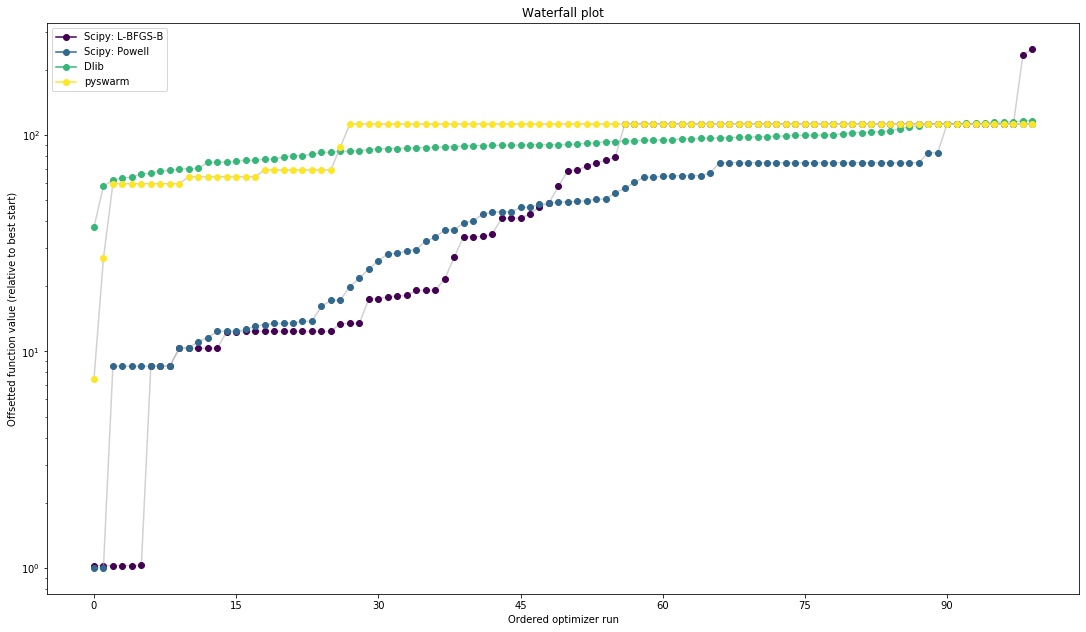

In [13]:
optimizer_results = [result_lbfgsb, result_powell, result_dlib, result_pyswarm]
optimizer_names = ['Scipy: L-BFGS-B', 'Scipy: Powell', 'Dlib', 'pyswarm']

pypesto.visualize.waterfall(optimizer_results, legends = optimizer_names);

## Optimizer run time

Optimizer run time vastly differs among the different optimizers, as can be seen below:

In [14]:
print('Average Run time per start:') 
print('-------------------')

for optimizer_name, optimizer_result in zip(optimizer_names, optimizer_results):
    t = np.sum(optimizer_result.optimize_result.get_for_key('time'))/n_starts
    print(f'{optimizer_name}: {t:f} s')

Average Run time per start:
-------------------
Scipy: L-BFGS-B: 3.327784 s
Scipy: Powell: 18.523545 s
Dlib: 114.969435 s
pyswarm: 26.666935 s


# Fitting of large scale models

When fitting large scale models (i.e. with >100 parameters and accordingly also more data), two important issues are efficient gradient computation and parallelization.

## Efficient gradient computation

As seen in the example above and as can be confirmed from own experience: If fast and reliable gradients can be provided, gradients based optimizers are favourable with respect to omptimizer convergence and run time.  

It has been shown, that adjoint sensitivity analysis propose a fast and reliable method to compute gradients for large scale models, since their run time is (asymptotically) independent of the number of parameters ([Fröhlich et al. PlosCB 2017](https://journals.plos.org/ploscompbiol/article/file?id=10.1371/journal.pcbi.1005331&type=printable)).

<img src="img/adjoint_sensitivities.png" width="40%" alt="pyPESTO logo"/> 

(Figure from Fröhlich et al. PlosCB 2017) Adjoint sensitivities are implemented in AMICI.

In [15]:
# Set gradient computation method to adjoint
problem.objective.amici_solver.setSensitivityMethod(amici.SensitivityMethod.adjoint)

## Parallelization

Multi-start optimization can easily be parallelized by using `engines`.

In [16]:
%%time
%%capture

# Parallelize
engine = pypesto.engine.MultiProcessEngine()

# Optimize
result = optimize.minimize(problem=problem, 
                           optimizer=optimizer_scipy_lbfgsb,
                           engine=engine,
                           n_starts=100)

CPU times: user 639 ms, sys: 123 ms, total: 762 ms
Wall time: 2min 4s


# Uncertainty quantification

PyPESTO focuses on two approaches to assess parameter uncertainties:

* Profile likelihoods
* Sampling

## Profile Likelihoods

[Profile likelihoods](https://academic.oup.com/bioinformatics/article/25/15/1923/213246) compute confidence intervals via a [likelihood ratio test](https://en.wikipedia.org/wiki/Likelihood-ratio_test). Profile likelihoods perform a maximum-projection of the likelihood function on the parameter of interest. The likelihood ratio test then gives a cut off criterium via the $\chi^2_1$ distribution.

In pyPESTO, the maximum projection is solved as maximization problem and can be obtained via

In [17]:
%%time
%%capture

import pypesto.profile as profile

result = profile.parameter_profile(problem=problem, 
                                   result=result, 
                                   optimizer=optimizer_scipy_lbfgsb)

CPU times: user 2min 31s, sys: 3.04 s, total: 2min 34s
Wall time: 2min 35s


The maximum projections can now be inspected via:

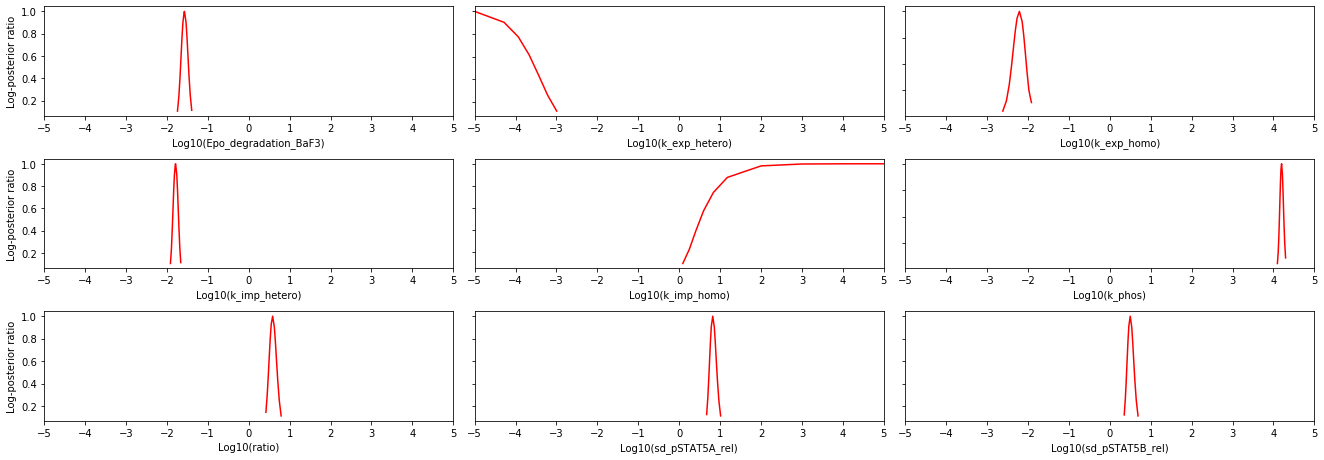

In [18]:
# adapt x_labels..
x_labels = [f'Log10({name})' for name in problem.x_names]

visualize.profiles(result, x_labels = x_labels, show_bounds=True);

The plot shows that seven parameters are identifiable, since the likelihood is tightly centered around the optimal parameter. Two parameters (`k_exp_hetero` and `k_imp_homo`) can not be constrained by the data.

Furthermore pyPESTO allows to visualize confidence intervals directly via

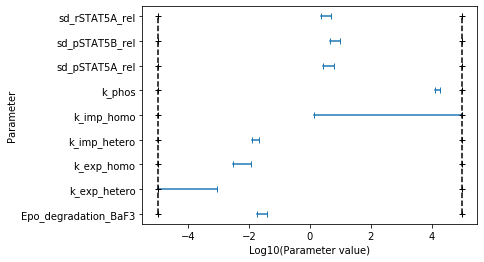

In [19]:
ax = pypesto.visualize.profile_cis(result, confidence_level=0.95, show_bounds=True)

ax.set_xlabel('Log10(Parameter value)');

## Sampling

In pyPESTO, sampling from the posterior distribution can be performed as 

In [20]:
import pypesto.sample as sample

n_samples = 10000

sampler = sample.AdaptiveMetropolisSampler()

result = sample.sample(problem, 
                       n_samples=n_samples, 
                       sampler=sampler, 
                       result=result)

100%|██████████| 10000/10000 [00:15<00:00, 639.72it/s]


Sampling results are stored in `result.sample_result` and can be accessed e.g. via

In [21]:
result.sample_result['trace_x']

array([[[-1.56900629, -5.        , -2.20988706, ...,  0.58569857,
          0.81885024,  0.49858734],
        [-1.56900629, -5.        , -2.20988706, ...,  0.58569857,
          0.81885024,  0.49858734],
        [-1.56900629, -5.        , -2.20988706, ...,  0.58569857,
          0.81885024,  0.49858734],
        ...,
        [-1.45281943, -4.79210839, -2.11016358, ...,  0.72403878,
          0.89979679,  0.50501028],
        [-1.45281943, -4.79210839, -2.11016358, ...,  0.72403878,
          0.89979679,  0.50501028],
        [-1.39789461, -4.74095578, -2.02333061, ...,  0.69529337,
          0.91745543,  0.53270201]]])

### Samlping Diagnostics

Gewekes test accesses convergence of a sampling run and computes the burn in of a sampling result. The effective sample size indicates the strenght the correlation between different samples.

In [22]:
sample.geweke_test(result=result)
result.sample_result['burn_in']

0

In [23]:
sample.effective_sample_size(result=result)
result.sample_result['effective_sample_size']

22.50800649784044

### Visualization of Sampling Results

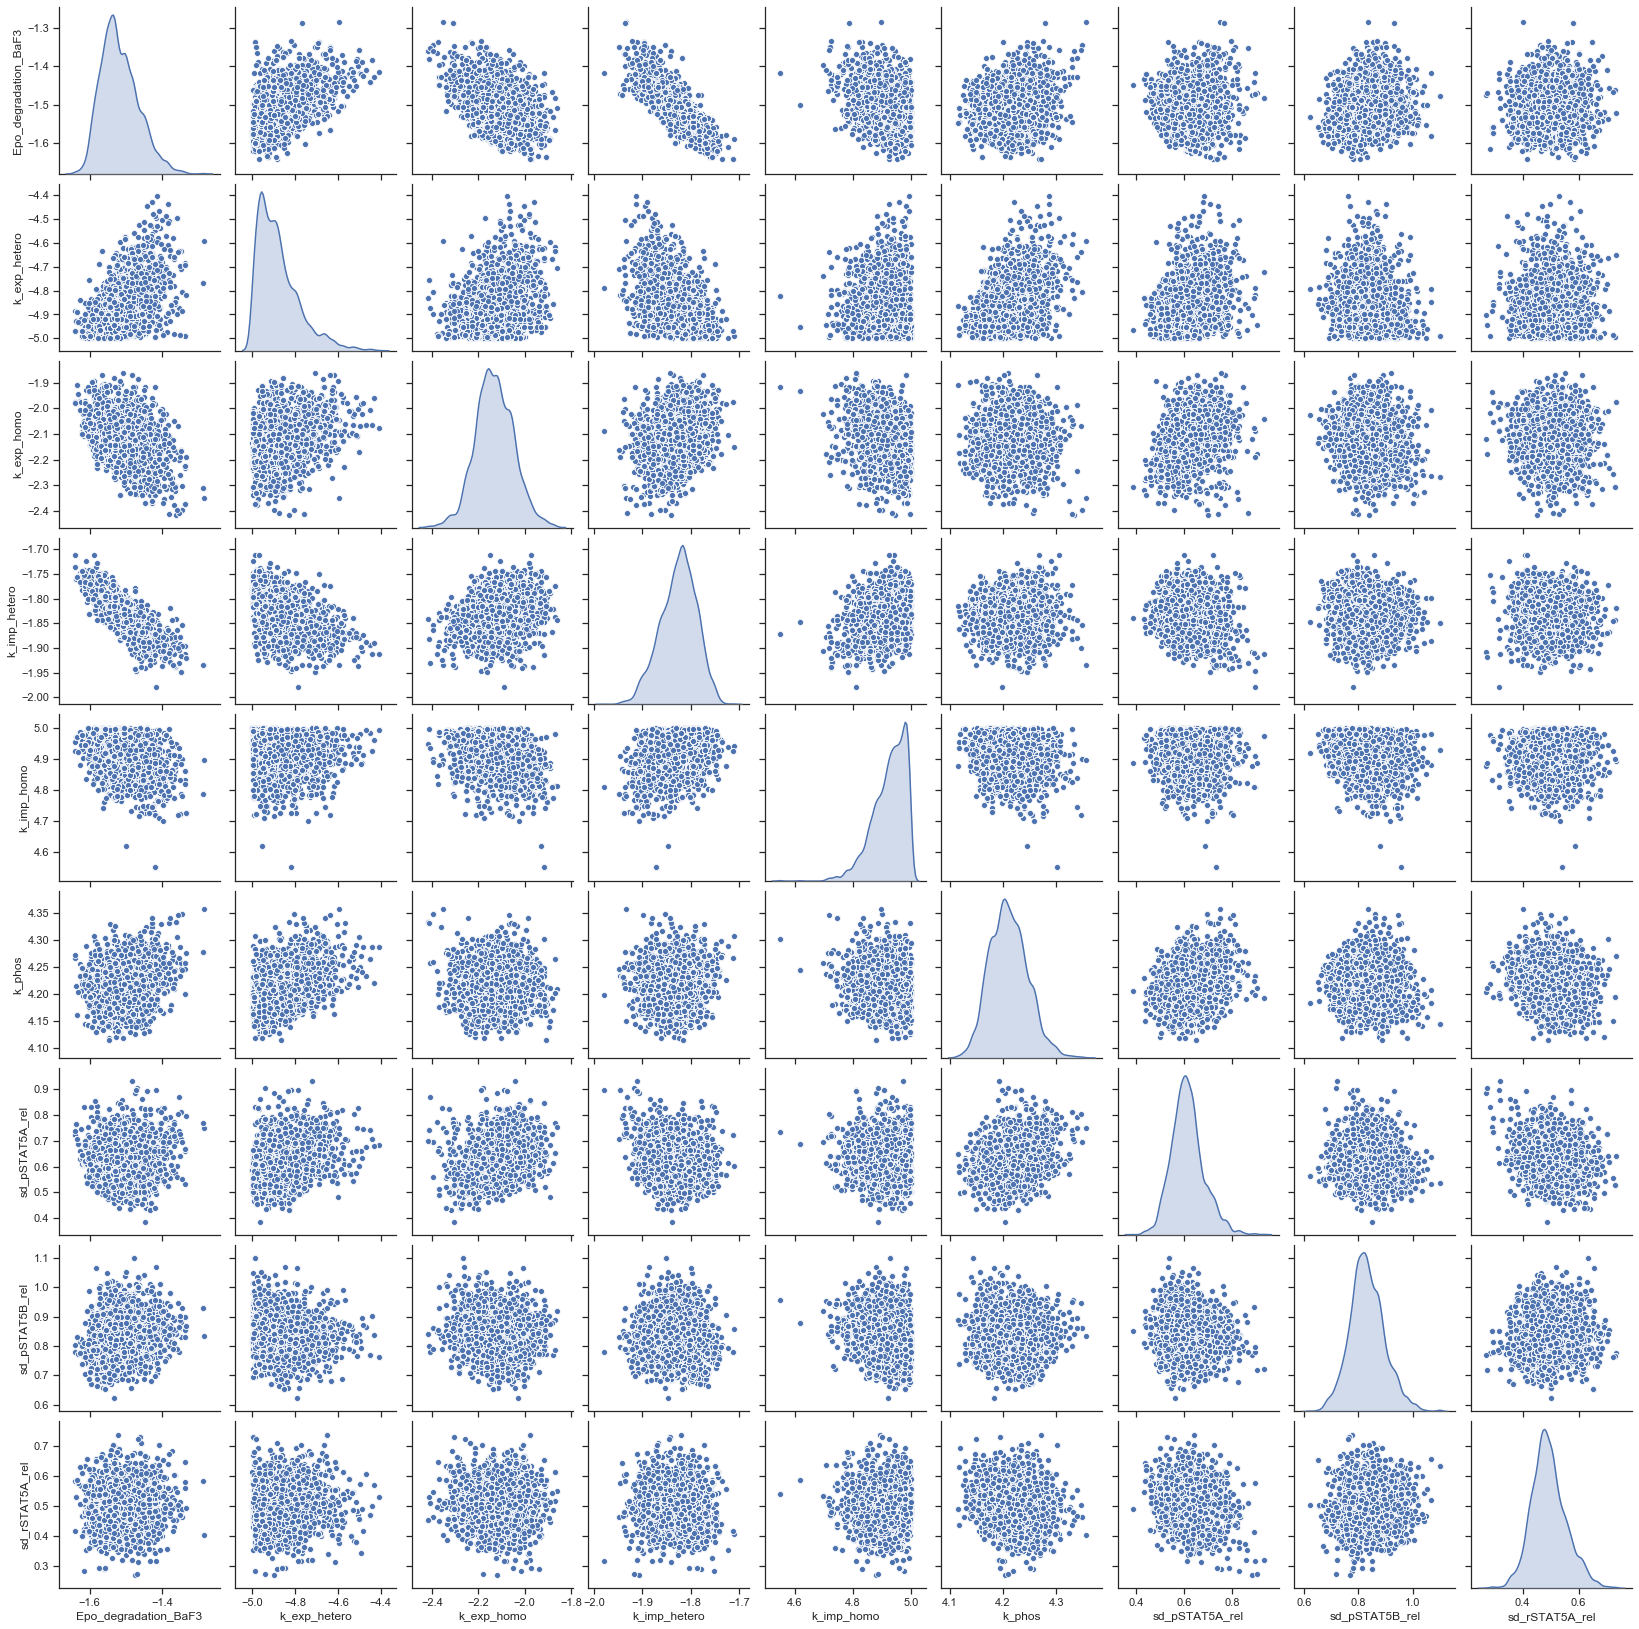

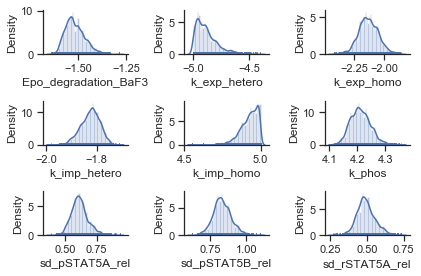

In [24]:
# scatter plots
ax = visualize.sampling_scatter(result)

# marginals
ax = visualize.sampling_1d_marginals(result)

## Sampler Choice:

Similarly to parameter optimization, pyPESTO provides a unified interface to several sampler/sampling toolboxes, as well as own implementations of sampler:

* Adaptive Metropolis:   `sample.AdaptiveMetropolisSampler()`
* Adaptive parallel tempering:   `sample.ParallelTemperingSampler()`
* Interface to `pymc3` via `sample.Pymc3Sampler()`

# Software Development Standards:

PyPESTO is developed with the following standards:

* **Open source**, code on [GitHub](https://github.com/ICB-DCM/pyPESTO).
* [**Pip installable**](https://pypi.org/project/pypesto/) via: `pip install pypesto`.
* **Documentation** as [RDT](https://pypesto.readthedocs.io/en/stable/) and [example **jupyter notebooks**](https://github.com/ICB-DCM/pyPESTO/tree/master/doc/example) are available.
* Has **continous integration** & extensive automated **testing** via travis.
* **Code reviews** before merging into the develop/master branch.

* Currently **5-10 people are using, extending** and (most importantly) **maintaining** pyPESTO in their "daily business".

# Outlook

Currently the following features are actively developed:

* Extending the number of Optimizer/Sampler (special focus on gradient free optimizers)
* Model Selection
* Experimental Design
* Hierarchical Optimization of scaling/noise parameters
* Categorial Data